# TikTok Claim vs. Opinion Classifier

With misinformation rising on short-form video platforms, I designed and evaluated a language model that distinguishes factual claims from personal opinions in TikTok content. I used bag-of-words CountVectorizer implemented in  and achieved an accuracy score of 100%.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer


## Load, Clean, and Split the Data

In [2]:
data = pd.read_csv("tiktok_dataset.csv")
data.shape

(19382, 12)

In [9]:
df = data[['video_transcription_text', 'claim_status']].copy()
del data
df.head()

,video_transcription_text,claim_status
0,someone shared with me that drone deliveries a...,claim
1,someone shared with me that there are more mic...,claim
2,someone shared with me that american industria...,claim
3,someone shared with me that the metro of st. p...,claim
4,someone shared with me that the number of busi...,claim


In [12]:
df.isna().sum()

video_transcription_text    298
claim_status                298
dtype: int64

In [13]:
df.shape

(19382, 2)

In [14]:
df.dropna(inplace=True)
df.isna().sum()


video_transcription_text    0
claim_status                0
dtype: int64

In [15]:
df.shape

(19084, 2)

In [20]:
y_train.value_counts(normalize=True)

claim_status
claim      0.5056
opinion    0.4944
Name: proportion, dtype: float64

## Representing Text Data as a Bag of Words

Computing the bag-of-words representation for a corpus of documents consists of the following three steps:
1. **Tokenization**. Split each document into the words that appear in it (called tokens),
for example by splitting them on whitespace and punctuation.
2. **Vocabulary building**. Collect a vocabulary of all words that appear in any of the
documents, and number them (say, in alphabetical order).
3. **Encoding**. For each document, count how often each of the words in the vocabu‐
lary appear in this document.

The output is one vector of word counts for each document. For each word in the vocabulary, we have a count of how often it appears in each document. That means our numeric representation has one feature for each unique word in the whole dataset.

In [21]:
vect = CountVectorizer().fit(train_text)


In [22]:
print(f"Vocabulary size: {len(vect.vocabulary_)}")
# print(f"Vocabulary content:\n {vect.vocabulary_}")


Vocabulary size: 1285


In [23]:

X_train = vect.transform(train_text)
X_test = vect.transform(test_text)

print(f"bag_of_words: {repr(X_train)}")


bag_of_words: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 218374 stored elements and shape (15267, 1285)>


In [24]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 1280 to 1284:\n{}".format(feature_names[1280:1284]))
print("Every 200th feature:\n{}".format(feature_names[::200]))


Number of features: 1285
First 20 features:
['000' '10' '100' '11' '12' '120mph' '13' '14' '15' '150' '16' '163' '17'
 '170' '1832' '1860' '1900' '1900s' '1905' '1920']
Features 1280 to 1284:
['you' 'your' 'zealanders' 'zero']
Every 200th feature:
['000' 'billions' 'egypt' 'individual' 'on' 'sense' 'until']


In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=7)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))


Mean cross-validation accuracy: 1.00


In [26]:
lr = LogisticRegression().fit(X_train, y_train)
lr.score(X_test, y_test)

1.0

### Improving Tokenization
The `CountVectorizer` extracts tokens using a regular expression. By default, the regular expression that is
used is "\b\w\w+\b".  It finds all sequences of characters that consist of at least two letters or numbers.<br>
This simple mechanism works quite well in practice, but as we saw earlier, we get
many uninformative features (like the numbers). One way to cut back on these is to
only use tokens that appear in at least two documents (or at least five documents, and
so on). A token that appears only in a single document is unlikely to appear in the test
set and is therefore not helpful. We can set the minimum number of documents a
token needs to appear in with the `min_df` parameter:


In [27]:
vect = CountVectorizer(min_df=5).fit(train_text)
X_train = vect.transform(train_text)
print("X_train with min_df: {}".format(repr(X_train)))


X_train with min_df: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 218374 stored elements and shape (15267, 1285)>


No change in our case but it should work in other applications.

### Stopwords
Another way that we can get rid of uninformative words is by discarding words that
are too frequent to be informative. There are two main approaches: using a languagespecific list of stopwords, or discarding words that appear too frequently. `scikitlearn` has a built-in list of English stopwords in the `feature_extraction.text`
module:


In [28]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))


Number of stop words: 318
Every 10th stopword:
['the', 'enough', 'back', 'everyone', 'third', 'wherein', 'herself', 'please', 'yourselves', 'otherwise', 'thereby', 'sometimes', 'bill', 'therein', 'anyway', 'now', 'seems', 'thru', 'without', 'hereby', 'such', 'co', 'do', 'and', 'up', 'twenty', 'noone', 'move', 'somehow', 'all', 'sixty', 'might']


In [29]:
vect = CountVectorizer(min_df=5, stop_words="english").fit(train_text)
X_train = vect.transform(train_text)
print("X_train without stop words:\n{}".format(repr(X_train)))


X_train without stop words:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 122244 stored elements and shape (15267, 1151)>


## Rescaling the Data with tf–idf (term frequency–inverse document frequency)
The intuition of this method is to give high weight to any term that appears
often in a particular document, but not in many documents in the corpus. If a word
appears often in a particular document, but not in very many documents, it is likely
to be very descriptive of the content of that document. `scikit-learn` implements the
**tf–idf** method in two classes: `TfidfTransformer`, which takes in the sparse matrix
output produced by `CountVectorizer` and transforms it, and `TfidfVectorizer`,
which takes in the text data and does both the bag-of-words feature extraction and
the tf–idf transformation.

<left><img src="../Assets/2- tf-idf Formula.png" width=700></left>


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None), LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5)

grid.fit(train_text, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))


Best cross-validation score: 1.00


In [31]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset
X_train = vectorizer.transform(train_text)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names_out())
print("Features with lowest tfidf:\n{}".format(
 feature_names[sorted_by_tfidf[:20]]))
print("Features with highest tfidf: \n{}".format(
 feature_names[sorted_by_tfidf[-20:]]))


Features with lowest tfidf:
['my' 'that' 'claim' 'read' 'learned' 'media' 'colleague' 'family'
 'colleagues' 'news' 'has' 'than' 'earth' 'only' 'willing' 'and' 'have'
 'view' 'will' 'more']
Features with highest tfidf: 
['population' 'them' 'located' 'water' 'fear' 'french' 'banana' 'who'
 'pound' 'usd' 'worth' 'pineapple' 'jobs' 'baked' 'metro' 'sales'
 'language' 'king' 'rainbow' 'pumpkins']


Features with low tf–idf are those that either are very commonly used across documents or are only used sparingly, and only in very long documents.

In [36]:
grid.cv_results_

{'mean_fit_time': array([0.39159985, 0.25340223, 0.27780261, 0.29040675, 0.3118011 ]),
 'std_fit_time': array([0.20225649, 0.01986679, 0.05940188, 0.05831516, 0.0738312 ]),
 'mean_score_time': array([0.07759972, 0.0551971 , 0.05079699, 0.05699172, 0.05420198]),
 'std_score_time': array([0.03074194, 0.00892962, 0.00811024, 0.01538086, 0.00560307]),
 'param_logisticregression__C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0],
              mask=[False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'logisticregression__C': 0.001},
  {'logisticregression__C': 0.01},
  {'logisticregression__C': 0.1},
  {'logisticregression__C': 1},
  {'logisticregression__C': 10}],
 'split0_test_score': array([1., 1., 1., 1., 1.]),
 'split1_test_score': array([1., 1., 1., 1., 1.]),
 'split2_test_score': array([1., 1., 1., 1., 1.]),
 'split3_test_score': array([1., 1., 1., 1., 1.]),
 'split4_test_score': array([1., 1., 1., 1., 1.]),
 'mean_test_score': array([1., 1., 1., 1., 1.]),
 

In [22]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
 feature_names[sorted_by_idf[:100]]))


Features with lowest idf:
['that' 'the' 'is' 'my' 'in' 'of' 'on' 'to' 'are' 'claim' 'read' 'learned'
 'someone' 'media' 'friend' 'colleague' 'discovered' 'an' 'friends'
 'world' 'family' 'colleagues' 'from' 'can' 'news' 'has' 'our' 'than' 'by'
 'earth' 'only' 'willing' 'internet' 'their' 'and' 'there' 'was' 'have'
 'view' 'first' 'will' 'more' 'be' 'for' 'around' 'most' 'over' 'it'
 'website' 'online' 'forum' 'revealed' 'discussion' 'board' 'social'
 'opinion' 'one' 'were' 'say' 'with' 'as' 'average' 'humans' 'car'
 'system' 'largest' 'day' 'claiming' 'about' 'mentioning' 'impression'
 'at' 'year' 'people' 'understanding' 'moon' 'position' 'thinking'
 'sentiment' 'hypothesis' 'times' 'belief' 'feeling' 'time' 'number'
 'solar' 'point' 'american' 'reasoning' 'two' 'planet' 'every' 'wager'
 'days' 'up' 'convinced' 'longest' 'never' 'when' 'single']


### Investigating Model Coefficients


In [23]:
import tools

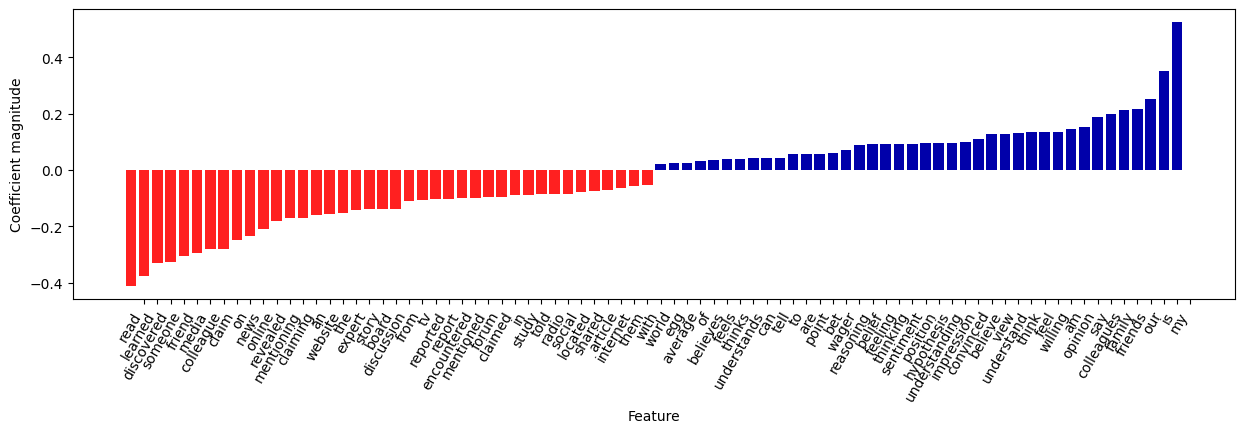

In [24]:
tools.visualize_coefficients( grid.best_estimator_.named_steps["logisticregression"].coef_,
 feature_names, n_top_features=40)

## Bag-of-Words with More Than One Word (n-Grams)
One of the main disadvantages of using a bag-of-words representation is that word
order is completely discarded. Therefore, the two strings “it’s bad, not good at all” and
“it’s good, not bad at all” have exactly the same representation, even though the mean‐
ings are inverted. Putting “not” in front of a word is only one example (if an extreme
one) of how context matters. Fortunately, there is a way of capturing context when
using a bag-of-words representation, by not only considering the counts of single
tokens, but also the counts of pairs or triplets of tokens that appear next to each other.
Pairs of tokens are known as bigrams, triplets of tokens are known as trigrams, and
more generally sequences of tokens are known as n-grams. We can change the range
of tokens that are considered as features by changing the `ngram_range` parameter of
`CountVectorizer` or `TfidfVectorizer`. The `ngram_range` parameter is a tuple, consisting of the minimum length and the maximum length of the sequences of tokens that are considered.

In [34]:

cv = CountVectorizer(ngram_range=(1, 3)).fit(train_text)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names_out()))


Vocabulary size: 10662
Vocabulary:
['000' '000 calories' '000 calories in' ... 'zones' 'zones around'
 'zones around the']


## Advanced Tokenization, Stemming, and Lemmatization
The feature extraction in the `CountVectorizer` and `Tfidf
Vectorizer` is relatively simple, and much more elaborate methods are possible.<br>
We saw earlier that the vocabulary often contains singular and plural versions of
some words, as in "drawback" and "drawbacks", "drawer" and "drawers", and
"drawing" and "drawings". For the purposes of a bag-of-words model, the semantics
of "drawback" and "drawbacks" are so close that distinguishing them will only
increase overfitting, and not allow the model to fully exploit the training data. 
Similarly, we found the vocabulary includes words like "replace", "replaced", "replace
ment", "replaces", and "replacing", which are different verb forms and a noun
relating to the verb “to replace.” Similarly to having singular and plural forms of a
noun, treating different verb forms and related words as distinct tokens is 
disadvantageous for building a model that generalizes well.<br>

This problem can be overcome by representing each word using its word stem, which
involves identifying (or conflating) all the words that have the same word stem.
- If this is done by using a rule-based heuristic, like dropping common suffixes, it is usually
referred to as **stemming**.
- If instead a dictionary of known word forms is used (an explicit and human-verified system), and the role of the word in the sentence is taken into account, the process is referred to as **lemmatization** and the standardized form of
the word is referred to as the **lemma**.<br>

Both processing methods, **lemmatization** and
**stemming**, are forms of **normalization** that try to extract some normal form of a
word. In general, lemmatization is a much more involved process than stemming, but it usually produces better results than stemming when used for normalizing tokens for machine learning.<br>

Another interesting case of normalization is spelling correction, which can be
helpful in practice.